# Training Classifier Wrist

In [1]:
!pip install -U --pre efficientnet

     |████████████████████████████████| 51kB 4.5MB/s 


In [29]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import tensorflow as tf
import cv2

import seaborn as sns
from PIL import Image

from tqdm import tqdm_notebook,tqdm


from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16,preprocess_input,decode_predictions
from keras.layers import  Convolution2D,MaxPooling2D,Dense,Flatten,Dropout,GlobalMaxPooling1D
from keras.layers import AveragePooling2D
from keras.models import  Sequential
import imutils
from keras.applications.resnet import ResNet50,ResNet152,preprocess_input,decode_predictions
from keras.applications.densenet import DenseNet121,DenseNet169,preprocess_input,decode_predictions
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
import efficientnet.keras as efn 


from google.colab import files
from sklearn.metrics import auc

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
bp='WRIST'

# Generating MetaDataframes

In [5]:
def returnDf(bodypart,path):

  train_imgs_path=pd.read_csv(path+'MURA-v1.1/train_image_paths.csv',names=['img_path'])
  test_imgs_path=pd.read_csv(path+'MURA-v1.1/valid_image_paths.csv',names=['img_path'])


  train_imgs_path['Body_Part']=train_imgs_path['img_path'].apply(lambda x: str(x.split('/')[2])[3:])
  train_imgs_path['Study_No']=train_imgs_path['img_path'].apply(lambda x: str(x.split('/')[4])[:6])
  train_imgs_path['label']=train_imgs_path['img_path'].apply(lambda x: str(x.split('/')[4])[7:])
  train_imgs_path['Patient_No']=train_imgs_path['img_path'].apply(lambda x: str(x.split('/')[3])[7:])

  test_imgs_path['Body_Part']=test_imgs_path['img_path'].apply(lambda x: str(x.split('/')[2])[3:])
  test_imgs_path['Study_No']=test_imgs_path['img_path'].apply(lambda x: str(x.split('/')[4])[:6])
  test_imgs_path['label']=test_imgs_path['img_path'].apply(lambda x: str(x.split('/')[4])[7:])
  test_imgs_path['Patient_No']=test_imgs_path['img_path'].apply(lambda x: str(x.split('/')[3])[7:])


  train_df=train_imgs_path[train_imgs_path['Body_Part']==bodypart]
  test_df=test_imgs_path[test_imgs_path['Body_Part']==bodypart]

  train_df['img_path']=[path + i for i in train_df['img_path']]
  test_df['img_path']=[path + i for i in test_df['img_path']]
  
  #train_labels['Body_Part']=train_labels['img_path'].apply(lambda x: str(x.split('/')[2])[3:])
  #train_labels['Study_Type']=train_labels['img_path'].apply(lambda x: str(x.split('/')[4])[:6])
  #test_labels['Body_Part']=test_labels['img_path'].apply(lambda x: str(x.split('/')[2])[3:])
  #test_labels['Study_Type']=test_labels['img_path'].apply(lambda x: str(x.split('/')[4])[:6])


  #train_labels['img_path']=train_imgs_path.iloc[:,0]
  #test_labels['img_path']=test_imgs_path.iloc[:,0]
    
  #train_df=train_labels[train_labels['Body_Part']==bodypart]
  #test_df=test_labels[test_labels['Body_Part']==bodypart]
  #train_df['img_path']=[path + i for i in train_df['img_path']]
  #train_df['label']=train_df['label'].astype('str')
  #test_df['img_path']=[path + i for i in test_df['img_path']]
  #test_df['label']=test_df['label'].astype('str')
  train_df['label']=[str(1) if i=='positive' else str(0) for i in train_df['label']]
  test_df['label']=[str(1) if i=='positive' else str(0) for i in test_df['label']]

  

  return train_df, test_df

In [6]:
train_df,test_df=returnDf(bp,'gdrive/My Drive/Capstone Medical Imaging/Data.nosync/')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [7]:
train_df.head()

,img_path,Body_Part,Study_No,label,Patient_No
19688,gdrive/My Drive/Capstone Medical Imaging/Data....,WRIST,study1,1,06359
19689,gdrive/My Drive/Capstone Medical Imaging/Data....,WRIST,study1,1,06359
19690,gdrive/My Drive/Capstone Medical Imaging/Data....,WRIST,study1,1,06360
19691,gdrive/My Drive/Capstone Medical Imaging/Data....,WRIST,study1,1,06360
19692,gdrive/My Drive/Capstone Medical Imaging/Data....,WRIST,study1,1,06360


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9752 entries, 19688 to 29439
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   img_path    9752 non-null   object
 1   Body_Part   9752 non-null   object
 2   Study_No    9752 non-null   object
 3   label       9752 non-null   object
 4   Patient_No  9752 non-null   object
dtypes: object(5)
memory usage: 457.1+ KB


In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 659 entries, 0 to 658
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   img_path    659 non-null    object
 1   Body_Part   659 non-null    object
 2   Study_No    659 non-null    object
 3   label       659 non-null    object
 4   Patient_No  659 non-null    object
dtypes: object(5)
memory usage: 30.9+ KB


In [10]:
 train_df['img_path'].iloc[1]

'gdrive/My Drive/Capstone Medical Imaging/Data.nosync/MURA-v1.1/train/XR_WRIST/patient06359/study1_positive/image2.png'

In [11]:
train_df['label'].value_counts()

0    5765
1    3987
Name: label, dtype: int64

In [12]:
test_df['label'].value_counts()

0    364
1    295
Name: label, dtype: int64

Baseline accuracy on training is 59%

In [13]:
train_df.head().iterrows()

<generator object DataFrame.iterrows at 0x7fddb25bf8e0>

5it [00:29,  5.84s/it]


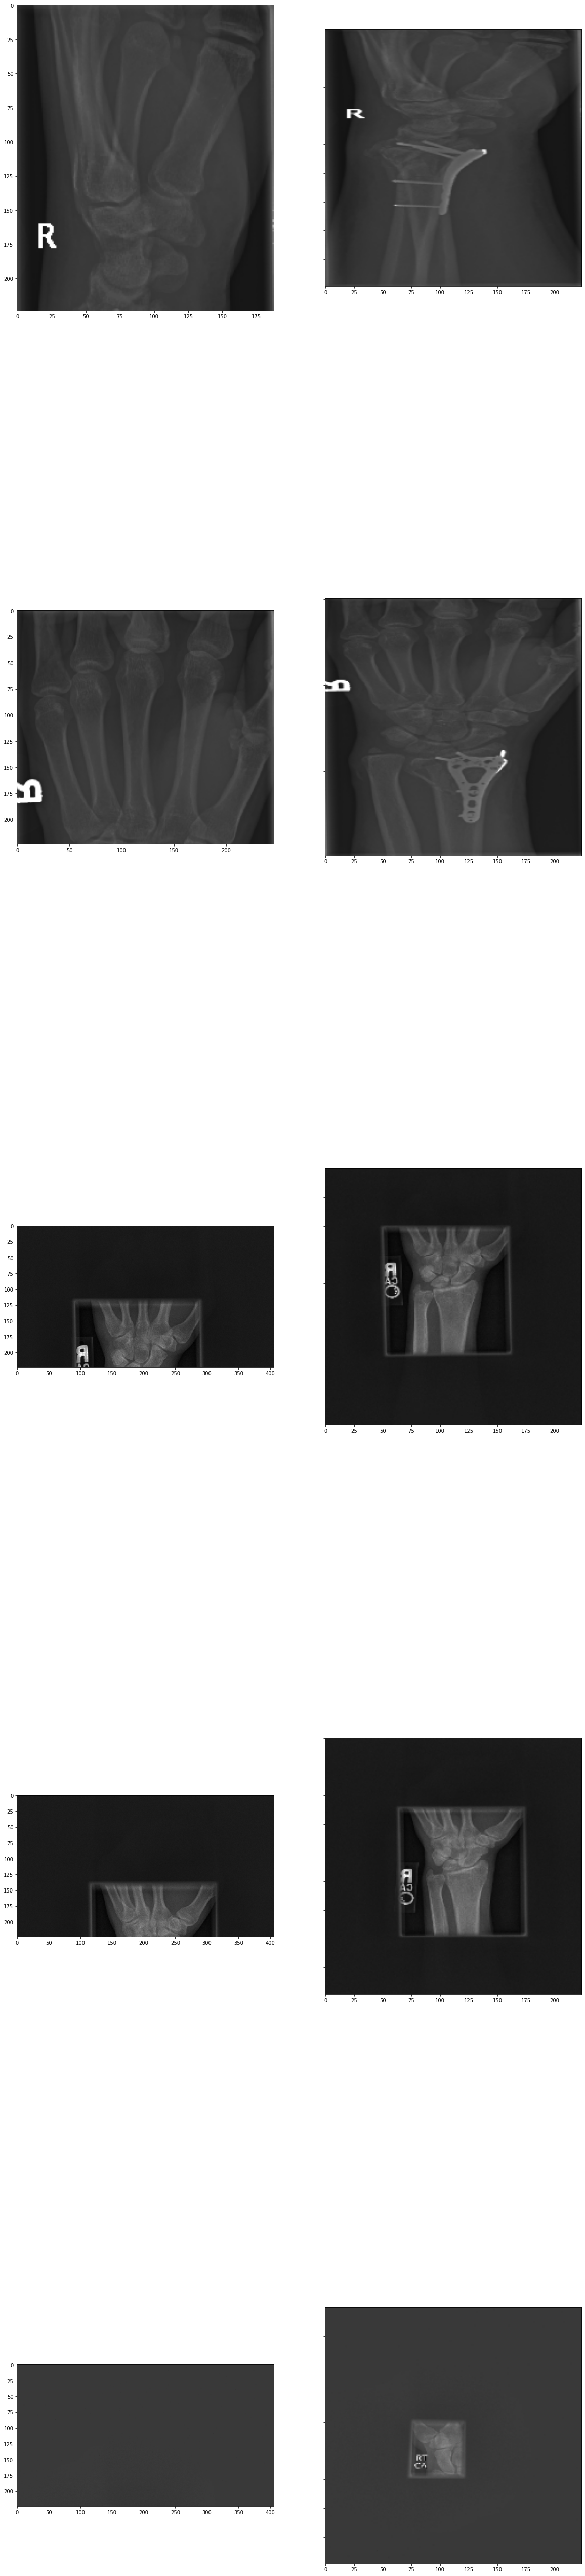

In [14]:
fig,ax=plt.subplots(5,2,sharey=True,figsize=(20,100))
image_dict={}
image_dict['images']=[]
image_dict['label']=[]
count=0
for index,row in tqdm(train_df.head().iterrows()):
  img_arr=cv2.imread(row['img_path'])
  ax[count,0].imshow(img_arr)
  
  resized_arr=cv2.resize(img_arr,(224,224))
  
  ax[count,1].imshow(resized_arr)
  count+=1
                     
  

#image_dict['images']=(image_dict['images']-mean_imagenet)/std_imagenet

# Creating image generators with simple preprocessing and options for data augmentation

In [15]:
def returnImgGen(train_df,test_df,IMG_SIZE=(224,224),rotation_range=0,horizontal_flip=False):
  datagen=ImageDataGenerator(
    horizontal_flip=horizontal_flip,
    #vertical_flip=True,
    rotation_range=rotation_range,
    #fill_mode='nearest',
    #preprocessing_function=preprocess_input)
    rescale=1./255.)



  train_gen=datagen.flow_from_dataframe(train_df,
                           x_col='img_path',
                           y_col='label',
                           target_size=IMG_SIZE,
                           color_mode='rgb',
                           class_mode='binary',batch_size=8,seed=101,shuffle=False)

  
    
  val_gen=datagen.flow_from_dataframe(test_df,
                           x_col='img_path',
                           y_col='label',
                           target_size=IMG_SIZE,
                           color_mode='rgb',
                           class_mode='binary', batch_size=1,seed=101,shuffle=False)
    
    
  return train_gen, val_gen



In [ ]:
train_gen_224,val_gen_224=returnImgGen(train_df,test_df)

Found 9752 validated image filenames belonging to 2 classes.
Found 659 validated image filenames belonging to 2 classes.


In [16]:
def plot_val_train_loss(hist):
  loss_train = hist.history['loss']
  loss_val = hist.history['val_loss']
  epochs = range(1,len(hist.history['val_loss'])+1)
  plt.plot(epochs, loss_train, 'g', label='Training loss')
  plt.plot(epochs, loss_val, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

# Augmented Data Image Generators

In [17]:
train_gen_aug,val_gen_aug=returnImgGen(train_df,test_df,IMG_SIZE=(224,224),rotation_range=30,horizontal_flip=True)

Found 9752 validated image filenames belonging to 2 classes.
Found 659 validated image filenames belonging to 2 classes.


# DenseNet169 with Augmentation

In [21]:
weight_path="{}_weights.best.hdf5".format('best_densenet_'+bp+'_classifier')

checkpoint3 = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat3 = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', min_lr=0.000001)
#epsilon=0.0001, cooldown=5
early3 = EarlyStopping(monitor='val_loss', patience=10, verbose=1, min_delta=1e-4) # probably needs to be more patient, but kaggle time is limited
callbacks_list_3 = [checkpoint3, early3, reduceLROnPlat3]

opt=keras.optimizers.Adam(learning_rate=0.001)
model17=Sequential()
model17.add(DenseNet169(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg'))
model17.add(Flatten())
model17.add(Dense(1, activation='sigmoid'))
model17.compile(loss='binary_crossentropy',optimizer=opt,metrics = ['accuracy','mse'])
model17.summary()



51879936/51877672 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 1664)              12642880  
_________________________________________________________________
flatten (Flatten)            (None, 1664)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1665      
Total params: 12,644,545
Trainable params: 12,486,145
Non-trainable params: 158,400
_________________________________________________________________


In [ ]:
history17=model17.fit(train_gen_aug,validation_data=val_gen_aug,epochs=30,callbacks=callbacks_list_3,shuffle=True)

In [ ]:
plot_val_train_loss(history17)

NameError: ignored

In [ ]:
files.download("best_densenet_"+bp+"_classifier_weights.best.hdf5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
def eval_model(model,val_gen):
  val_gen.reset()
  Y_p=model.predict(val_gen)

  predictions = []
  for p in Y_p:
    if(p > 0.5):
        predictions+=[1]
    else:
        predictions+=[0]
  print('Confusion Matrix')
  print(confusion_matrix(val_gen.classes, predictions))
  print('Classification Report')
  target_names = ['Normal','Abnormal']
  print(classification_report(val_gen.classes, predictions, target_names=target_names))


  fpr_keras, tpr_keras, thresholds_keras = roc_curve(val_gen.classes, predictions)
  auc_keras = auc(fpr_keras, tpr_keras)

  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.show()

  plt.figure(2)
  plt.xlim(0.0, 0.2)
  plt.ylim(0.65, 0.9)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve (zoomed in at top left)')
  plt.legend(loc='best')
  plt.show()

In [24]:
model17.load_weights('/content/best_densenet_'+bp.lower()+'_classifier_weights.best.hdf5')

Confusion Matrix
[[336  28]
 [ 99 196]]
Classification Report
              precision    recall  f1-score   support

      Normal       0.77      0.92      0.84       364
    Abnormal       0.88      0.66      0.76       295

    accuracy                           0.81       659
   macro avg       0.82      0.79      0.80       659
weighted avg       0.82      0.81      0.80       659



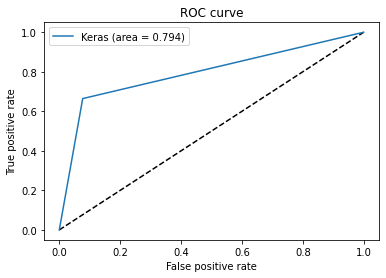

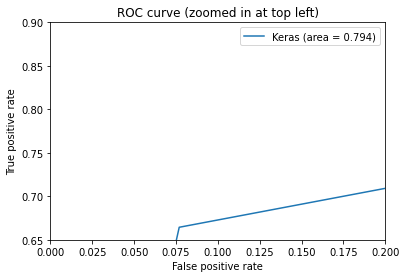

In [31]:
eval_model(model17,val_gen_aug)

# ResNet with Augmentation

In [ ]:
weight_path="{}_weights.best.hdf5".format('cardio_attn')

checkpoint3 = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat3 = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', min_lr=0.000001)
#epsilon=0.0001, cooldown=5
early3 = EarlyStopping(monitor='val_loss', patience=10, verbose=1, min_delta=1e-4) # probably needs to be more patient, but kaggle time is limited
callbacks_list_3 = [checkpoint3, early3, reduceLROnPlat3]

opt=keras.optimizers.Adam(learning_rate=0.001)
model18=Sequential()
model18.add(ResNet152(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg'))
model18.add(Flatten())
model18.add(Dense(1, activation='sigmoid'))
model18.compile(loss='binary_crossentropy',optimizer=opt,metrics = ['accuracy','mse'])
model18.summary()

history18=model18.fit(train_gen_aug,validation_data=val_gen_aug,epochs=30,callbacks=callbacks_list_3,shuffle=True)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Functional)       (None, 2048)              58370944  
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 2049      
Total params: 58,372,993
Trainable params: 58,221,569
Non-trainable params: 151,424
_________________________________________________________________
Epoch 1/30
1219/1219 [==============================] - ETA: 0s - loss: 0.7200 - accuracy: 0.5829 - mse: 0.2528
Epoch 00001: val_loss improved from inf to 1.11311, saving model to cardio_attn_weights.best.hdf5
1219/1219 [==============================] - 177s 145ms/step - loss: 0.7200 - accuracy: 0.5829 - mse: 0.2528 - val_loss: 1.1131 - val_accuracy: 0.5524 - val

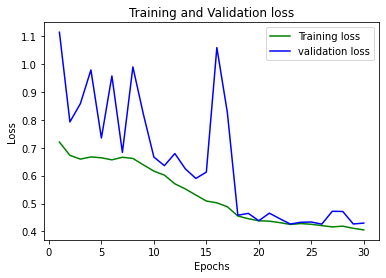

In [ ]:
plot_val_train_loss(history18)

# EfficientNet with Augmentation

In [33]:
weight_path="{}_weights.best.hdf5".format('best_efficientnet0_wrist_classifier')

checkpoint3 = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat3 = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', min_lr=0.000001)
#epsilon=0.0001, cooldown=5
early3 = EarlyStopping(monitor='val_loss', patience=10, verbose=1, min_delta=1e-4) # probably needs to be more patient, but kaggle time is limited
callbacks_list_3 = [checkpoint3, early3, reduceLROnPlat3]

opt=keras.optimizers.Adam(learning_rate=0.001)
model19=Sequential()
model19.add(efn.EfficientNetB0(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg'))
model19.add(Flatten())
model19.add(Dense(1, activation='sigmoid'))
model19.compile(loss='binary_crossentropy',optimizer=opt,metrics = ['accuracy','mse'])
model19.summary()



16809984/16804768 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 1280)              4049564   
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 4,050,845
Trainable params: 4,008,829
Non-trainable params: 42,016
_________________________________________________________________


In [ ]:
history19=model19.fit(train_gen_aug,validation_data=val_gen_aug,epochs=30,callbacks=callbacks_list_3,shuffle=True)

In [ ]:
files.download("best_efficientnet0_wrist_classifier_weights.best.hdf5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Confusion Matrix
[[350  14]
 [ 74 221]]
Classification Report
              precision    recall  f1-score   support

      Normal       0.83      0.96      0.89       364
    Abnormal       0.94      0.75      0.83       295

    accuracy                           0.87       659
   macro avg       0.88      0.86      0.86       659
weighted avg       0.88      0.87      0.86       659



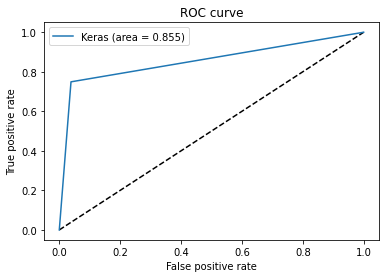

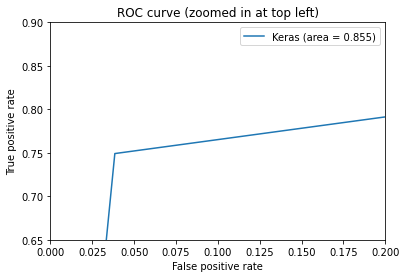

In [34]:
model19.load_weights('/content/best_efficientnet0_'+bp.lower()+'_classifier_weights.best.hdf5')
eval_model(model19,val_gen_aug)